In [1]:
import numpy as np
import random
from numpy import linalg
import itertools as it
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import linregress
import pandas as pd

In [2]:
def generate_ground_state_set_GHZ(max_hd, degeneracy):
    """Generate a set of ground states with a guaranteed max_hd and at least one GHZ pairing (0 and max_hd)"""
    gs_set = {0, (2**max_hd) - 1}
    while len(gs_set) < degeneracy:
        gs_set.add(random.getrandbits(max_hd))
    return list(gs_set)

def generate_ground_state_set_random(max_hd, degeneracy, N):
    """Generate a set of ground states with specified degeneracy."""
    gs_set = {0}
    
    # Generate the first state by flipping the first max_hd bits
    next_gs = 0
    for i in range(max_hd):
        next_gs ^= (1 << i)  # Flip the ith bit
    gs_set.add(next_gs)
    last_gs = next_gs

    # Generate the remaining states
    while len(gs_set) < degeneracy:
        next_gs = last_gs
        for _ in range(max_hd):
            i = random.randint(0, N - 1)
            next_gs ^= (1 << i)  # Flip the ith bit
        gs_set.add(next_gs)
        last_gs = next_gs

    return list(gs_set)

def calculate_hamming_distances(gs_array, degeneracy):
    """Calculate Hamming distances and spins involved from the ground state array."""
    
    hd_list = []
    hd_matrix = np.zeros((degeneracy, degeneracy))
    spins_involved = 0
    


    for gs_i in range(degeneracy):
        for gs_j in range(gs_i + 1, degeneracy):
            binary_diff = gs_array[gs_i] ^ gs_array[gs_j]
            h_d = binary_diff.bit_count()
            hd_list.append(h_d)
            hd_matrix[gs_i][gs_j] = hd_matrix[gs_j][gs_i] = h_d
            spins_involved |= binary_diff

    return hd_list, hd_matrix, spins_involved.bit_count()

def compute_overlap_distribution(hd_list, N, degeneracy):
    """Compute the overlap distribution and related statistics."""
    overlap_dist = np.zeros(N + 1)
    overlap_dist[-1] = 1 / degeneracy

    for hd in hd_list:
        overlap_dist[-hd - 1] += 2 / (degeneracy**2)

    od_bins = np.array([((2 * i) / N) - 1 for i in range(N + 1)])
    od_mean = np.sum(od_bins * overlap_dist)
    od_var = np.sum(overlap_dist * (od_bins - od_mean) ** 2)

    return overlap_dist, od_mean, od_var


def compute_dist(hd_matrix: np.ndarray, N:int, degeneracy:int):

        gs_indeces = [i for i in range(degeneracy)]
        splittings = []
        for D in it.combinations(gs_indeces, degeneracy // 2):
            A = tuple(gs_i for gs_i in gs_indeces if gs_i not in D)
            splittings.append((D, A))


        

        dist_list = np.zeros(len(splittings))

        

        for i in range(len(splittings)):
            D = list(splittings[i][0])
            A = list(splittings[i][1])

            d_list = np.zeros(len(D))
            for j, gs_j in enumerate(D):
                d_list[j] = np.min(hd_matrix[gs_j, A]) * (1 / degeneracy)
            dist_list[i] = 2 * np.sum(d_list)

        return max(dist_list) / N

In [10]:
N = 100
num_samples = 100
degen_range = [2, 11]
data_list_ghz = []

for degeneracy in range(degen_range[0], degen_range[1]):
    for max_hd in range(int(np.ceil(np.log2(degeneracy))), N + 1):
        for _ in range(num_samples):
            # Generate ground state set
            gs_array = generate_ground_state_set_GHZ(max_hd, degeneracy)

            # Calculate Hamming distances and spins involved
            hd_list, hd_matrix, spins_involved = calculate_hamming_distances(gs_array, degeneracy)

            # Compute overlap distribution and statistics
            dist = compute_dist(hd_matrix,N, degeneracy)

            # Append results to the data list
            data_list_ghz.append([spins_involved, dist, degeneracy])



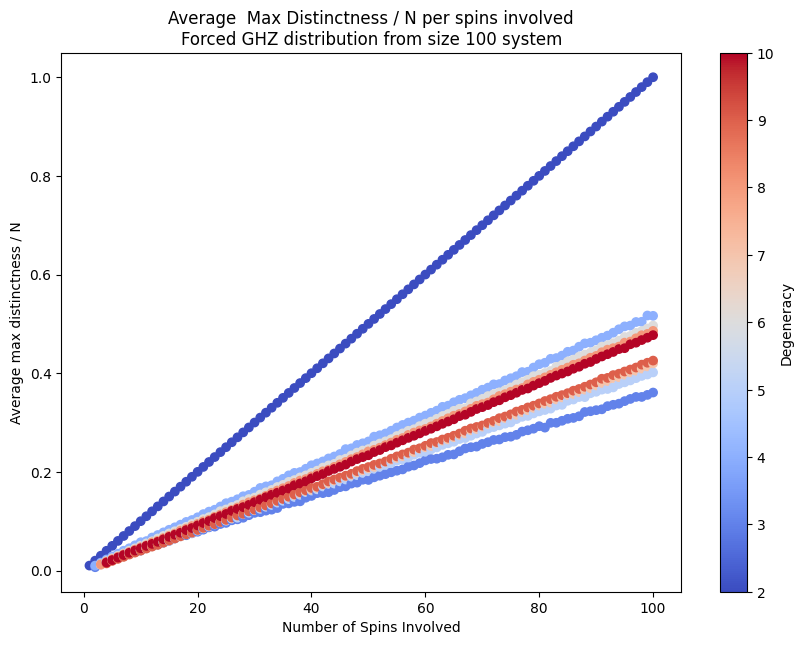

In [7]:
df = pd.DataFrame(data_list_ghz, columns=['si', 'dist', 'deg'])
plot_df = df.groupby(['si','deg'])['dist'].mean().reset_index()


cmap = plt.cm.coolwarm
norm = Normalize(vmin=degen_range[0], vmax=degen_range[1] - 1)
plt.figure(figsize=(10,7))
plt.scatter(x=plot_df['si'], y=plot_df['dist'], c=plot_df["deg"], cmap=cmap, norm=norm)
plt.xlabel("Number of Spins Involved")
plt.ylabel("Average max distinctness / N")
plt.title(f"Average  Max Distinctness / N per spins involved\nForced GHZ distribution from size {N} system")
plt.colorbar(label='Degeneracy')
plt.show()

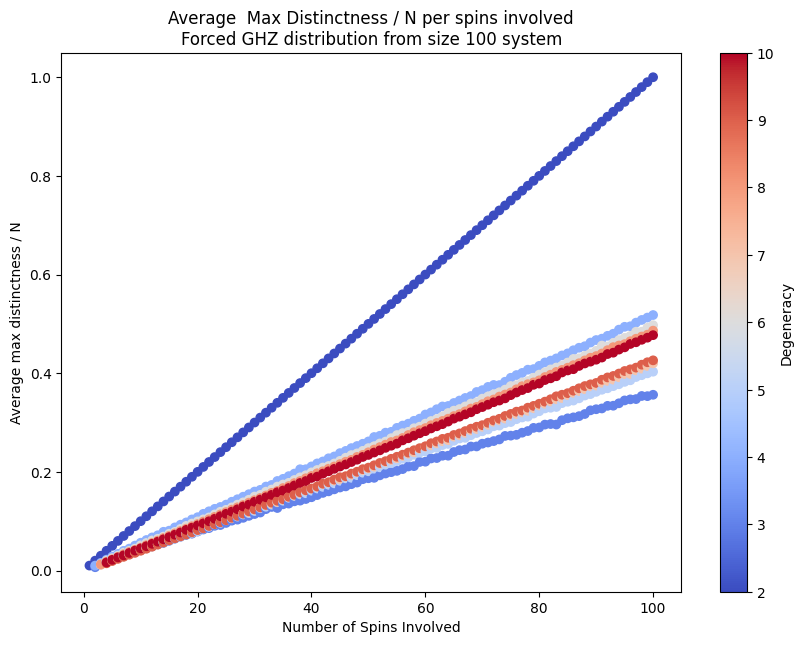

In [11]:
df = pd.DataFrame(data_list_ghz, columns=['si', 'dist', 'deg'])
plot_df = df.groupby(['si','deg'])['dist'].mean().reset_index()


cmap = plt.cm.coolwarm
norm = Normalize(vmin=degen_range[0], vmax=degen_range[1] - 1)
plt.figure(figsize=(10,7))
plt.scatter(x=plot_df['si'], y=plot_df['dist'], c=plot_df["deg"], cmap=cmap, norm=norm)
plt.xlabel("Number of Spins Involved")
plt.ylabel("Average max distinctness / N")
plt.title(f"Average  Max Distinctness / N per spins involved\nForced GHZ distribution from size {N} system")
plt.colorbar(label='Degeneracy')
plt.show()

In [9]:
degeneracy = 7
gs_indeces = [i for i in range(degeneracy)]
splittings = []
for D in it.combinations(gs_indeces, degeneracy // 2):
    A = tuple(gs_i for gs_i in gs_indeces if gs_i not in D)
    splittings.append((D, A))

print(splittings)


[((0, 1, 2), (3, 4, 5, 6)), ((0, 1, 3), (2, 4, 5, 6)), ((0, 1, 4), (2, 3, 5, 6)), ((0, 1, 5), (2, 3, 4, 6)), ((0, 1, 6), (2, 3, 4, 5)), ((0, 2, 3), (1, 4, 5, 6)), ((0, 2, 4), (1, 3, 5, 6)), ((0, 2, 5), (1, 3, 4, 6)), ((0, 2, 6), (1, 3, 4, 5)), ((0, 3, 4), (1, 2, 5, 6)), ((0, 3, 5), (1, 2, 4, 6)), ((0, 3, 6), (1, 2, 4, 5)), ((0, 4, 5), (1, 2, 3, 6)), ((0, 4, 6), (1, 2, 3, 5)), ((0, 5, 6), (1, 2, 3, 4)), ((1, 2, 3), (0, 4, 5, 6)), ((1, 2, 4), (0, 3, 5, 6)), ((1, 2, 5), (0, 3, 4, 6)), ((1, 2, 6), (0, 3, 4, 5)), ((1, 3, 4), (0, 2, 5, 6)), ((1, 3, 5), (0, 2, 4, 6)), ((1, 3, 6), (0, 2, 4, 5)), ((1, 4, 5), (0, 2, 3, 6)), ((1, 4, 6), (0, 2, 3, 5)), ((1, 5, 6), (0, 2, 3, 4)), ((2, 3, 4), (0, 1, 5, 6)), ((2, 3, 5), (0, 1, 4, 6)), ((2, 3, 6), (0, 1, 4, 5)), ((2, 4, 5), (0, 1, 3, 6)), ((2, 4, 6), (0, 1, 3, 5)), ((2, 5, 6), (0, 1, 3, 4)), ((3, 4, 5), (0, 1, 2, 6)), ((3, 4, 6), (0, 1, 2, 5)), ((3, 5, 6), (0, 1, 2, 4)), ((4, 5, 6), (0, 1, 2, 3))]
